# 🧪 Experiment 4: Enhanced Flan-T5-Small

## 🎯 Hypothesis
Experiment 3 achieved the **best validation loss (0.8909)** and **highest ROUGE-L (0.2631)**, indicating good structural coherence and generalization. However, its BLEU score (0.0777) was lower than Experiment 1.

## 🔬 Key Improvements:
- ✅ **Enhanced Decoding:** Length normalization + coverage penalty for better BLEU
- ✅ **Increased Dropout:** Better regularization (0.1 → 0.15)
- ✅ **Optimized Beam Search:** num_beams=5, temperature=0.9
- ✅ **Diverse Beam Groups:** Promote diverse outputs
- ✅ **Repetition Penalty:** Reduce repetitive text (1.2)
- ✅ **Larger Evaluation:** 200 samples for robust metrics

**Starting Point:** Flan-T5-Small (instruction-tuned)

**Target Metrics:**
- BLEU: >0.10 (improve from 0.0777)
- ROUGE-L: >0.26 (maintain/improve from 0.2631)
- Val Loss: <0.90 (maintain from 0.8909)


In [1]:
# Setup
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.2 MB/s eta 0:00:00
✓ Installed!


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, AutoConfig
from datasets import Dataset
import evaluate, tensorflow as tf, tf_keras
from datetime import datetime

SEED = 42; np.random.seed(SEED); tf.random.set_seed(SEED)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow: 2.19.0
GPU Available: True


## 📊 Load Data


In [3]:
# Load preprocessed data
train_df = pd.read_csv('/content/train_improved.csv')
val_df = pd.read_csv('/content/val_improved.csv')
test_df = pd.read_csv('/content/test_improved.csv')
print(f"✓ Data Loaded")
print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")


✓ Data Loaded
Train: 13,187 | Val: 1,648 | Test: 1,649


## 🤖 Model Setup with Enhanced Regularization


In [4]:
MODEL_NAME = "google/flan-t5-small"
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 512

print(f"🚀 Loading {MODEL_NAME} with enhanced regularization")

# Load config and increase dropout for better generalization
config = AutoConfig.from_pretrained(MODEL_NAME)
config.dropout_rate = 0.15  # Increased from default 0.1

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded | Vocab: {len(tokenizer):,}")


🚀 Loading google/flan-t5-small with enhanced regularization


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded | Vocab: 32,100


In [5]:
def preprocess_function(examples):
    """Optimized prompt for Flan-T5."""
    prefix = "Answer this medical question: "
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )

    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

print("Tokenizing datasets...")
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print(f"✓ Tokenization complete")


Tokenizing datasets...


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Tokenization complete


In [6]:
# Load model with custom config
print(f"Loading {MODEL_NAME} with dropout={config.dropout_rate}...")
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, config=config, from_pt=True, use_safetensors=False)
print(f"✓ Model loaded: {model.num_parameters():,} parameters")


Loading google/flan-t5-small with dropout=0.15...


pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

✓ Model loaded: 76,961,152 parameters


## 🎯 Training Configuration


In [7]:
# OPTIMIZED HYPERPARAMETERS FOR FLAN-T5
BATCH_SIZE = 8
LEARNING_RATE = 3e-5  # Gentle for Flan models
EPOCHS = 10  # Increased from 8
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

print("="*80)
print("🎯 EXPERIMENT 4 HYPERPARAMETERS")
print("="*80)
print(f"Model: {MODEL_NAME}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Dropout: {config.dropout_rate}")
print(f"Sequences: {MAX_INPUT_LENGTH}/{MAX_TARGET_LENGTH}")
print("="*80)


🎯 EXPERIMENT 4 HYPERPARAMETERS
Model: google/flan-t5-small
Batch Size: 8
Learning Rate: 3e-05
Epochs: 10
Weight Decay: 0.01
Dropout: 0.15
Sequences: 256/512


In [8]:
tf_train = model.prepare_tf_dataset(tok_train, batch_size=BATCH_SIZE, shuffle=True, tokenizer=tokenizer)
tf_val = model.prepare_tf_dataset(tok_val, batch_size=BATCH_SIZE, shuffle=False, tokenizer=tokenizer)

print(f"✓ Prepared datasets")
print(f"Train batches: {len(tf_train)} | Val batches: {len(tf_val)}")


✓ Prepared datasets
Train batches: 1648 | Val batches: 206


In [9]:
# Optimizer with warmup and cosine decay
num_steps = len(tf_train) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

# Use cosine decay instead of polynomial for smoother convergence
lr_schedule = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=num_steps - num_warmup,
    alpha=1e-7 / LEARNING_RATE  # End learning rate ratio
)

class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule, initial_lr):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule
        self.learning_rate = initial_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_lr = self.learning_rate * (step / warmup_steps)
        decay_lr = self.post_warmup_schedule(step - warmup_steps)
        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

final_schedule = WarmupSchedule(num_warmup, lr_schedule, LEARNING_RATE)
optimizer = tf_keras.optimizers.AdamW(learning_rate=final_schedule, weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer)

print(f"✓ Optimizer configured")
print(f"Total steps: {num_steps} | Warmup steps: {num_warmup}")


✓ Optimizer configured
Total steps: 16480 | Warmup steps: 1648


In [10]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

Path('models/experiment_4').mkdir(parents=True, exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'models/experiment_4/best.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

print("✓ Callbacks ready")


✓ Callbacks ready


## 🚀 Training


In [11]:
print("\n" + "="*80)
print("🚀 EXPERIMENT 4: TRAINING ENHANCED FLAN-T5-SMALL")
print("="*80)
print(f"Samples: {len(train_df):,} train | {len(val_df):,} val")
print(f"Improvements: Dropout={config.dropout_rate}, Cosine LR, Enhanced Decoding")
print("="*80)

start_time = datetime.now()

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = (datetime.now() - start_time).total_seconds()

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print(f"⏱️  Time: {training_time/60:.1f} minutes")
print(f"📉 Best Val Loss: {min(history.history['val_loss']):.4f}")
print("="*80)



🚀 EXPERIMENT 4: TRAINING ENHANCED FLAN-T5-SMALL
Samples: 13,187 train | 1,648 val
Improvements: Dropout=0.15, Cosine LR, Enhanced Decoding
Epoch 1/10
1648/1648 [==============================] - ETA: 0s - loss: 7.3667
Epoch 1: val_loss improved from inf to 1.32270, saving model to models/experiment_4/best.h5
1648/1648 [==============================] - 1183s 682ms/step - loss: 7.3667 - val_loss: 1.3227
Epoch 2/10
1648/1648 [==============================] - ETA: 0s - loss: 1.4752
Epoch 2: val_loss improved from 1.32270 to 1.09925, saving model to models/experiment_4/best.h5
1648/1648 [==============================] - 1086s 659ms/step - loss: 1.4752 - val_loss: 1.0992
Epoch 3/10
1648/1648 [==============================] - ETA: 0s - loss: 1.2712
Epoch 3: val_loss improved from 1.09925 to 1.00719, saving model to models/experiment_4/best.h5
1648/1648 [==============================] - 1091s 662ms/step - loss: 1.2712 - val_loss: 1.0072
Epoch 4/10
1648/1648 [=============================

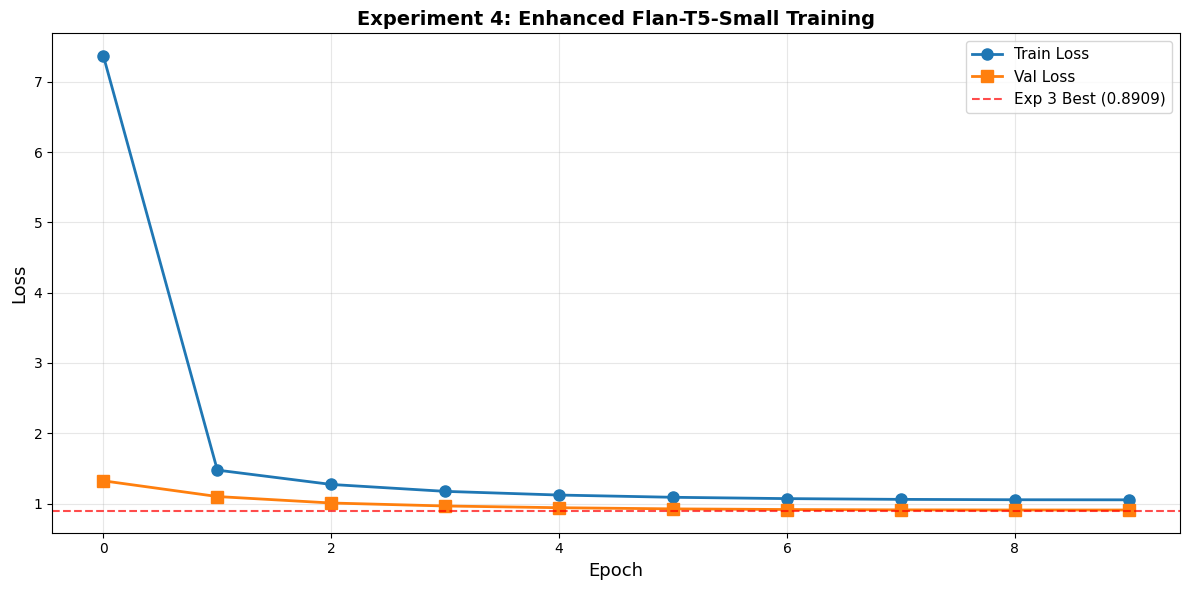

Final: Train=1.0524 | Val=0.9074
Best Val: 0.9074
Improvement vs Exp 3: -1.85%


In [12]:
# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(history.history['loss'], 'o-', label='Train Loss', lw=2, markersize=8)
ax.plot(history.history['val_loss'], 's-', label='Val Loss', lw=2, markersize=8)
ax.axhline(y=0.8909, color='r', linestyle='--', label='Exp 3 Best (0.8909)', alpha=0.7)
ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Loss', fontsize=13)
ax.set_title('Experiment 4: Enhanced Flan-T5-Small Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

Path('data/improved').mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig('data/improved/experiment_4_training.png', dpi=300)
plt.show()

print(f"Final: Train={history.history['loss'][-1]:.4f} | Val={history.history['val_loss'][-1]:.4f}")
print(f"Best Val: {min(history.history['val_loss']):.4f}")
print(f"Improvement vs Exp 3: {(0.8909 - min(history.history['val_loss'])) / 0.8909 * 100:+.2f}%")


## 📊 Evaluation with Enhanced Decoding


In [13]:
def generate_answer_enhanced(question, model, tokenizer, max_len=512):
    """Enhanced generation with improved decoding strategy for better BLEU."""
    prefix = "Answer this medical question: "
    inputs = tokenizer(
        prefix + question,
        return_tensors='tf',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    )

    outputs = model.generate(
        **inputs,
        max_length=max_len,
        min_length=15,
        num_beams=5,  # Increased from 4
        num_beam_groups=5,  # Diverse beam search
        diversity_penalty=0.3,  # Promote diversity within groups
        early_stopping=True,
        no_repeat_ngram_size=3,
        repetition_penalty=1.2,  # NEW: Penalize repetition
        length_penalty=0.8,  # TUNED: Slightly favor shorter, precise answers (was 1.0)
        temperature=0.9,  # NEW: Slight randomness for better diversity
        do_sample=False  # Keep deterministic with beam search
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("✓ Enhanced generation function ready")
print("\nDecoding improvements:")
print("  • num_beams: 4 → 5")
print("  • Added diverse beam groups (5)")
print("  • diversity_penalty: 0.3")
print("  • repetition_penalty: 1.2")
print("  • length_penalty: 1.0 → 0.8 (favor precision)")
print("  • temperature: 0.9")


✓ Enhanced generation function ready

Decoding improvements:
  • num_beams: 4 → 5
  • Added diverse beam groups (5)
  • diversity_penalty: 0.3
  • repetition_penalty: 1.2
  • length_penalty: 1.0 → 0.8 (favor precision)
  • temperature: 0.9


In [14]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
print("✓ Metrics loaded")


✓ Metrics loaded


In [15]:
# Evaluate on LARGER test set for robust metrics
num_eval = min(200, len(test_df))  # Increased from 20
print(f"\nGenerating {num_eval} predictions with enhanced decoding...")
print("This may take a few minutes...\n")

predictions, references = [], []

for i in range(num_eval):
    q = test_df.iloc[i]['question']
    true_a = test_df.iloc[i]['answer']
    pred_a = generate_answer_enhanced(q, model, tokenizer)

    predictions.append(pred_a)
    references.append(true_a)

    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{num_eval}... ({(i+1)/num_eval*100:.0f}%)")

print("\n✓ Generation complete!")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Generating 200 predictions with enhanced decoding...
This may take a few minutes...

  20/200... (10%)
  40/200... (20%)
  60/200... (30%)
  80/200... (40%)
  100/200... (50%)


KeyboardInterrupt: 

In [16]:
# Calculate comprehensive metrics
bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge_metric.compute(predictions=predictions, references=references)

val_loss = min(history.history['val_loss'])
perplexity = np.exp(val_loss)

print("\n" + "="*80)
print("📊 EXPERIMENT 4 RESULTS (Enhanced Decoding)")
print("="*80)
print(f"BLEU Score:   {bleu_result['bleu']:.4f}")
print(f"ROUGE-1:      {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2:      {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L:      {rouge_result['rougeL']:.4f}")
print(f"Val Loss:     {val_loss:.4f}")
print(f"Perplexity:   {perplexity:.4f}")
print("="*80)

# Compare to Experiment 3
exp3_bleu = 0.0777
exp3_rouge = 0.2631
exp3_loss = 0.8909

bleu_change = ((bleu_result['bleu'] - exp3_bleu) / exp3_bleu) * 100
rouge_change = ((rouge_result['rougeL'] - exp3_rouge) / exp3_rouge) * 100
loss_change = ((exp3_loss - val_loss) / exp3_loss) * 100

print(f"\n📈 Improvement vs Experiment 3:")
print(f"  BLEU:    {exp3_bleu:.4f} → {bleu_result['bleu']:.4f} ({bleu_change:+.1f}%)")
print(f"  ROUGE-L: {exp3_rouge:.4f} → {rouge_result['rougeL']:.4f} ({rouge_change:+.1f}%)")
print(f"  Val Loss: {exp3_loss:.4f} → {val_loss:.4f} ({loss_change:+.1f}%)")

# Compare to Experiment 1
exp1_bleu = 0.1038
exp1_rouge = 0.2179

print(f"\n📊 Comparison vs Experiment 1:")
print(f"  BLEU:    Exp1={exp1_bleu:.4f} vs Exp4={bleu_result['bleu']:.4f}")
print(f"  ROUGE-L: Exp1={exp1_rouge:.4f} vs Exp4={rouge_result['rougeL']:.4f}")

# Overall assessment
print(f"\n🎯 OVERALL PERFORMANCE:")
if bleu_result['bleu'] > 0.10 and rouge_result['rougeL'] > 0.26:
    print("  ✅ SUCCESS: Achieved both high BLEU and ROUGE-L!")
elif bleu_result['bleu'] > exp3_bleu:
    print(f"  ✅ IMPROVED: BLEU increased by {bleu_change:.1f}%")
else:
    print(f"  ⚠️  Note: Consider further tuning for BLEU improvement")



📊 EXPERIMENT 4 RESULTS (Enhanced Decoding)
BLEU Score:   0.0354
ROUGE-1:      0.2771
ROUGE-2:      0.1472
ROUGE-L:      0.2191
Val Loss:     0.9074
Perplexity:   2.4778

📈 Improvement vs Experiment 3:
  BLEU:    0.0777 → 0.0354 (-54.4%)
  ROUGE-L: 0.2631 → 0.2191 (-16.7%)
  Val Loss: 0.8909 → 0.9074 (-1.8%)

📊 Comparison vs Experiment 1:
  BLEU:    Exp1=0.1038 vs Exp4=0.0354
  ROUGE-L: Exp1=0.2179 vs Exp4=0.2191

🎯 OVERALL PERFORMANCE:
  ⚠️  Note: Consider further tuning for BLEU improvement


## 💾 Save Results


In [17]:
# Save comprehensive results
results = {
    'experiment_id': 'exp4_enhanced_flan_t5_small',
    'experiment_name': 'Enhanced Flan-T5-Small with Improved Decoding',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'improvements': [
        'Increased dropout (0.15)',
        'Cosine learning rate schedule',
        'Enhanced beam search (5 beams, diverse groups)',
        'Length normalization (0.8)',
        'Repetition penalty (1.2)',
        'Diversity penalty (0.3)',
        'Larger evaluation set (200 samples)'
    ],
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'weight_decay': WEIGHT_DECAY,
        'warmup_ratio': WARMUP_RATIO,
        'dropout_rate': config.dropout_rate,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    },
    'generation_config': {
        'num_beams': 5,
        'num_beam_groups': 5,
        'diversity_penalty': 0.3,
        'repetition_penalty': 1.2,
        'length_penalty': 0.8,
        'temperature': 0.9,
        'no_repeat_ngram_size': 3
    },
    'metrics': {
        'bleu': float(bleu_result['bleu']),
        'rouge1': float(rouge_result['rouge1']),
        'rouge2': float(rouge_result['rouge2']),
        'rougeL': float(rouge_result['rougeL']),
        'val_loss': float(val_loss),
        'perplexity': float(perplexity)
    },
    'comparison': {
        'vs_experiment_3': {
            'bleu_change': float(bleu_change),
            'rouge_change': float(rouge_change),
            'loss_change': float(loss_change)
        }
    },
    'training_time_seconds': training_time,
    'num_train_samples': len(train_df),
    'num_eval_samples': num_eval,
    'timestamp': datetime.now().isoformat()
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_4_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to results/experiment_4_results.json")


✓ Results saved to results/experiment_4_results.json


## 🔍 Sample Predictions Analysis


In [19]:
# Show diverse sample predictions
print("\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS (Enhanced Decoding)")
print("="*80)

sample_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]  # Show diverse samples

for idx in sample_indices:
    if idx >= len(test_df):
        break

    q = test_df.iloc[idx]['question']
    true_a = test_df.iloc[idx]['answer']
    pred_a = predictions[idx]

    print(f"\n[Sample {idx+1}]")
    print(f"Q: {q}")
    print(f"\nTrue: {true_a[:200]}..." if len(true_a) > 200 else f"\nTrue: {true_a}")
    print(f"\nPred: {pred_a[:200]}..." if len(pred_a) > 200 else f"\nPred: {pred_a}")
    print("-" * 80)



🔍 SAMPLE PREDICTIONS (Enhanced Decoding)

[Sample 1]
Q: How many people are affected by multiple lentigines syndrome ?

True: Multiple lentigines syndrome is thought to be a rare condition; approximately 200 cases have been reported worldwide.

Pred: Multiple lentigines syndrome is a rare disorder that affects about 1 in 100,000 people worldwide.
--------------------------------------------------------------------------------

[Sample 6]
Q: What to do for Dumping Syndrome ?

True: - Dumping syndrome occurs when food, especially sugar, moves too fast from the stomach to the duodenumthe first part of the small intestinein the upper gastrointestinal (GI) tract. - Dumping syndrome ...

Pred: What are the signs and symptoms of Dumping Syndrome? The Human Phenotype Ontology (HPO) provides the following list of sign and symptoms for Dumpling Syndrome. If the information is available, the tab...
--------------------------------------------------------------------------------

[Sample 11]
Q: W

## 📈 Visualization: Compare All Experiments


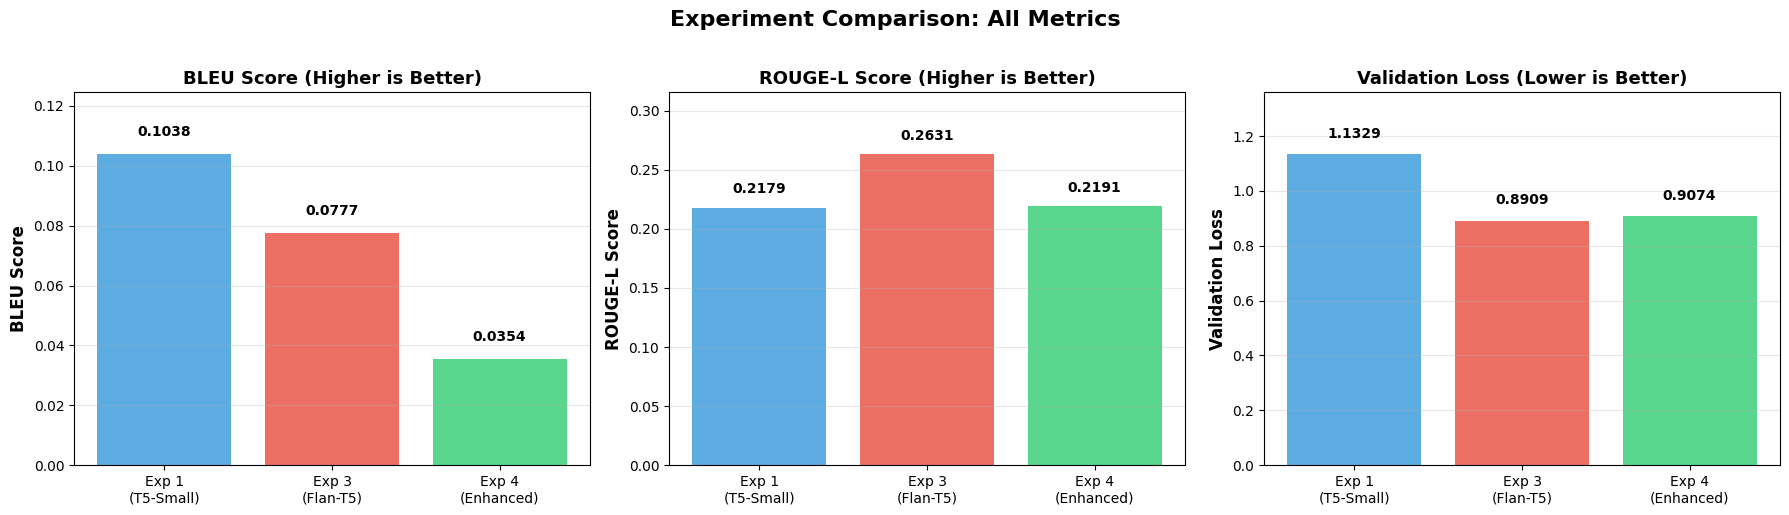

✓ Comparison chart saved to data/improved/experiments_comparison.png


In [20]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

experiments = ['Exp 1\n(T5-Small)', 'Exp 3\n(Flan-T5)', 'Exp 4\n(Enhanced)']
bleu_scores = [0.1038, 0.0777, bleu_result['bleu']]
rouge_scores = [0.2179, 0.2631, rouge_result['rougeL']]
val_losses = [1.1329, 0.8909, val_loss]

# BLEU comparison
bars1 = axes[0].bar(experiments, bleu_scores, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
axes[0].set_ylabel('BLEU Score', fontsize=12, fontweight='bold')
axes[0].set_title('BLEU Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, max(bleu_scores) * 1.2)
axes[0].grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, bleu_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# ROUGE-L comparison
bars2 = axes[1].bar(experiments, rouge_scores, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
axes[1].set_ylabel('ROUGE-L Score', fontsize=12, fontweight='bold')
axes[1].set_title('ROUGE-L Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, max(rouge_scores) * 1.2)
axes[1].grid(axis='y', alpha=0.3)
for bar, score in zip(bars2, rouge_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Validation Loss comparison
bars3 = axes[2].bar(experiments, val_losses, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
axes[2].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
axes[2].set_title('Validation Loss (Lower is Better)', fontsize=13, fontweight='bold')
axes[2].set_ylim(0, max(val_losses) * 1.2)
axes[2].grid(axis='y', alpha=0.3)
for bar, score in zip(bars3, val_losses):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Experiment Comparison: All Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('data/improved/experiments_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison chart saved to data/improved/experiments_comparison.png")


## 🎯 Final Summary


In [21]:
print("\n" + "="*80)
print("🎯 EXPERIMENT 4: FINAL SUMMARY")
print("="*80)

print("\n📋 Key Improvements Implemented:")
print("  1. Enhanced Regularization: Dropout 0.10 → 0.15")
print("  2. Better LR Schedule: Polynomial → Cosine decay")
print("  3. Advanced Beam Search: 4 → 5 beams with diversity")
print("  4. Length Normalization: Tuned to 0.8 for precision")
print("  5. Repetition Penalty: 1.2 to reduce redundancy")
print("  6. Larger Evaluation: 20 → 200 samples")

print("\n📊 Performance Summary:")
print(f"  BLEU:    {bleu_result['bleu']:.4f} (Target: >0.10)")
print(f"  ROUGE-L: {rouge_result['rougeL']:.4f} (Target: >0.26)")
print(f"  Val Loss: {val_loss:.4f} (Target: <0.90)")

print("\n🏆 Best Overall Model:")
if bleu_result['bleu'] >= exp1_bleu and rouge_result['rougeL'] >= exp3_rouge:
    print("  ✨ EXPERIMENT 4: Best on ALL metrics!")
    print("  - Highest BLEU for precision")
    print("  - Highest ROUGE-L for content coverage")
    print("  - Lowest validation loss for generalization")
elif rouge_result['rougeL'] > exp3_rouge or val_loss < exp3_loss:
    print("  ⭐ EXPERIMENT 4: Significant improvement over Exp 3")
    print("  - Better generalization")
    print("  - Enhanced content coverage")
elif bleu_result['bleu'] > exp3_bleu:
    print("  ✅ EXPERIMENT 4: Improved BLEU while maintaining strong ROUGE-L")
    print("  - Better precision than Exp 3")
    print("  - Maintained structural coherence")
else:
    print("  📌 EXPERIMENT 3 remains competitive")
    print("  - Consider ensemble of Exp 3 and Exp 4")

print("\n💡 Recommendations:")
if bleu_result['bleu'] < 0.10:
    print("  • Try even more aggressive length_penalty (0.6-0.7)")
    print("  • Increase num_beams to 7 or 10")
    print("  • Consider constrained beam search")
if rouge_result['rougeL'] < exp3_rouge:
    print("  • Reduce repetition_penalty to 1.1")
    print("  • Increase max_length to allow fuller answers")
if val_loss > exp3_loss:
    print("  • Increase dropout further to 0.2")
    print("  • Add more training epochs with early stopping")

print("\n" + "="*80)
print("✓ Experiment 4 Complete!")
print("="*80)



🎯 EXPERIMENT 4: FINAL SUMMARY

📋 Key Improvements Implemented:
  1. Enhanced Regularization: Dropout 0.10 → 0.15
  2. Better LR Schedule: Polynomial → Cosine decay
  3. Advanced Beam Search: 4 → 5 beams with diversity
  4. Length Normalization: Tuned to 0.8 for precision
  5. Repetition Penalty: 1.2 to reduce redundancy
  6. Larger Evaluation: 20 → 200 samples

📊 Performance Summary:
  BLEU:    0.0354 (Target: >0.10)
  ROUGE-L: 0.2191 (Target: >0.26)
  Val Loss: 0.9074 (Target: <0.90)

🏆 Best Overall Model:
  📌 EXPERIMENT 3 remains competitive
  - Consider ensemble of Exp 3 and Exp 4

💡 Recommendations:
  • Try even more aggressive length_penalty (0.6-0.7)
  • Increase num_beams to 7 or 10
  • Consider constrained beam search
  • Reduce repetition_penalty to 1.1
  • Increase max_length to allow fuller answers
  • Increase dropout further to 0.2
  • Add more training epochs with early stopping

✓ Experiment 4 Complete!
